In [1]:
import pandas as pd 
import numpy as np
from ts import Team,UpdateGamei
from Betting import *
from dataset import *
from Utils import *

In [2]:
Dataset=FootballDataset('E0_2022.csv')
data=Dataset.data
team_names=Dataset.team_names()
Under,Over=Dataset.get_odds()
Undercote,Overcote=[1/Under[i] for i in range(len(Under))],[1/Over[i] for i in range(len(Under))]
y=Dataset.get_y()
teams=[Team(i,team_names) for i in range(1,21)]

In [3]:
Dataset.Releguated(team_names)

[['Burnley', 35.0], ['Watford', 23.0], ['Norwich', 22.0]]

In [4]:
teams=[Team(i,team_names) for i in range(1,21)]


In [43]:
print_team_stats(teams)

The best Home attacking team is: Man City (11.349391639379753)
The best Home defensing team is: Liverpool (0.8084225390119161)
The best Away attacking team is: Man City (9.001185392327375)
The best Away defensing team: Liverpool (0.6219727435779443)


The three best overall teams with the highest average attacking attribute are:
Man City (20.35057703170713)
Liverpool (14.114290107427479)
Tottenham (12.975971961299638)
Arsenal (11.264608034879023)
Chelsea (10.620776651029225)


The three best overall teams with the highest average defending attribute are:
Liverpool (1.4303952825898603)
Tottenham (2.455544363399823)
Man City (2.7329186705499775)
Chelsea (3.7358520286908172)
Crystal Palace (4.5477095494305955)




In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
import numpy as np

def Predict(lam,phi1,phi2,teams,y,Over,Undercote,Overcote,mode):
    
    L=[]
    
    X=features_up_tomatchej(lam,phi1,phi2,len(data),Over,teams,team_names,data,Dataset,mode)
    
    
    E=np.arange(62,len(data)+1,10)
    
    logreg = LogisticRegression()
    T=Betting()
    
    # Create an empty array for concatenation
    all_probs = np.empty((0, 2))
    acc=0
    for i in range(len(E)-2):
        
        X_train,y_train=X[ E[0]-62:E[i+1]-62 ], y[ E[0]:E[i+1] ]        #### Features to train on 
        
        X_bet,y_bet=X[ E[i+1]-62 : E[i+2]-62 ], y[ E[i+1] : E[i+2] ]    ### 10 features ahead for bettings        
        
        logreg.fit(X_train,y_train)                                     ### Fitting

        logreg_prob=logreg.predict_proba(X_bet)                         ### Predicting

        prob=np.array(logreg_prob)                                      ### Probabilities
        
        # Concatenate the probabilities
        all_probs = np.concatenate([all_probs, prob])
        
        #Betting
        PROFIT=T.kellybetting_unitlist(prob,y_bet,Overcote[E[i+1]-62 : E[i+2]-62],Undercote[E[i+1]-62 : E[i+2]-62],0.1)
        L=np.concatenate([L,PROFIT])
    
        
        acc+=T.accuracy(y_bet,prob)
        
    
    loss=log_loss(y[E[1]:E[len(E)-1]],all_probs)
    accuracy=acc/len( y[ E[1]:E[len(E)-1 ]] )
    netreturn=T.stack_kelly_unit/T.number_of_bets
    return loss,netreturn,accuracy

In [47]:
Predict(2.96644798, 0.34056246, 0.17475957,teams,y,Over,Undercote,Overcote,'G')


(0.7108144338736487, 1.0133098561330331, 0.52)

In [56]:
from scipy.optimize import minimize
def maximize_Maine(lam, phi1, phi2):
    def objective_function(x):
        return Predict(x[0], x[1], x[2], teams,y,Over,Undercote,Overcote,'G')[0]
    
    bounds = [(0.1, 30), (0.1, 0.95), (0.1, 0.95)] # set the bounds for the first three parameters
    
    result = minimize(objective_function, x0=[lam, phi1, phi2], bounds=bounds,method='nelder-mead',options={'disp': True})
    Xr=result.x
    return Xr,Predict(Xr[0], Xr[1], Xr[2],teams,y,Over,Undercote,Overcote,'G')

In [58]:
maximize_Maine(1.5,0.5,0.5)

KeyboardInterrupt: 

In [59]:
A=np.linspace(0.1,1,20)
B=np.linspace(0.1,1,20)

Loss=np.zeros((len(A),len(B)))
profit=np.zeros((len(A),len(B)))
avgret=np.zeros((len(A),len(B)))
accuracy=np.zeros((len(A),len(B)))
for i in range(len(A)):
    for j in range(len(B)):
        
        a,b,c=Predict(1,A[i],B[j],teams,y,Over,Undercote,Overcote,'G')
        Loss[i][j]=a
        profit[i][j]=b
        
        

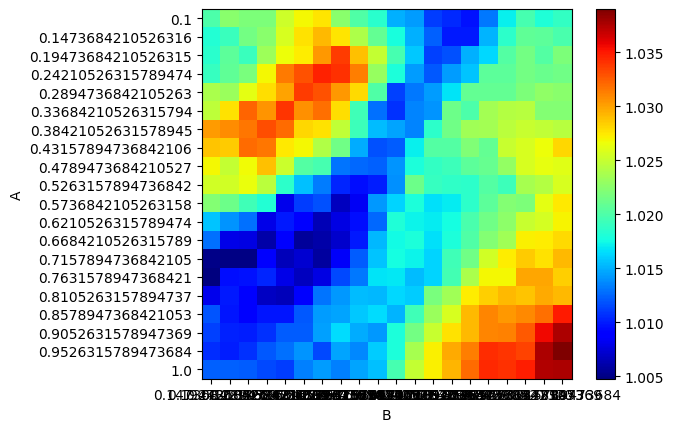

In [62]:
import matplotlib.pyplot as plt
import numpy as np

# Define A, B, and Result matrices


plt.imshow(profit,cmap='jet')
plt.xticks(np.arange(len(A)), A)
plt.xlabel('B')
plt.yticks(np.arange(len(B)), B)
plt.ylabel('A')
plt.colorbar()
plt.show()

In [29]:
D=np.multiply(profit,avgret)

In [33]:
maximum = np.max(avgret)
max_index = np.unravel_index(np.argmax(avgret, axis=None), profit.shape)
print(maximum,max_index)

1.0598848596194321 (13, 17)


In [35]:
maximum = np.max(accuracy)
max_index = np.unravel_index(np.argmax(accuracy, axis=None), profit.shape)
print(maximum,max_index)

0.5766666666666667 (5, 4)


In [63]:
maximum = np.min(Loss)
max_index = np.unravel_index(np.argmin(Loss, axis=None),Loss.shape)
print(maximum,max_index)

0.7056571073156316 (19, 19)
